# YOLOv8 训练自己的目标检测数据集

😋😋公众号算法美食屋后台回复关键词：**torchkeras**，获取本文notebook源代码和数据集下载链接。

本范例我们使用 torchkeras来实现对 ultralytics中的YOLOv8目标检测模型进行自定义的训练，从而检测气球。

尽管ultralytics提供了非常便捷且一致的训练API，再使用torchkeras实现自定义训练逻辑似乎有些多此一举。

但ultralytics的源码结构相对复杂，不便于用户做个性化的控制和修改。

并且，torchkeras在可视化上会比ultralytics的原生训练代码优雅许多。

不信的话，我们对比看看就明白啦。

此外，本文的内容对同学们熟悉ultralytics这个库的代码结构也会有帮助。


In [ ]:
#安装
#!pip install -U ultralytics -i https://pypi.tuna.tsinghua.edu.cn/simple
#!pip install -U torchkeras

In [1]:
import ultralytics 
ultralytics.checks()


Ultralytics YOLOv8.0.175 🚀 Python-3.8.10 torch-2.0.1+cu117 CUDA:0 (NVIDIA A100 80GB PCIe, 81070MiB)
Setup complete ✅ (96 CPUs, 377.1 GB RAM, 1813.8/3060.8 GB disk)


In [37]:
import warnings 
warnings.filterwarnings('ignore')


## 一，准备数据

公众号 算法美食屋 后台回复关键词：torchkeras，获取本文notebook代码和 balloon 数据集 下载地址。


### 1,格式转换

In [11]:
import os,json 
import numpy as np 
from pathlib import Path 
from shutil import copyfile 
from tqdm import tqdm
from PIL import Image 

root_path = './datasets/balloon/'

# 1,构建目录
data_root = Path(root_path)
for tp in ('images','labels'):
    for part in ('train','val'):
        (data_root/tp/part).mkdir(parents=True, exist_ok=True)
        
# 2,复制图片文件
train_images = [str(x) for x in Path('balloon/train/').rglob('*.jpg')]
val_images = [str(x) for x in Path('balloon/val/').rglob('*.jpg')]

for src_file in tqdm(train_images):
    name = os.path.basename(src_file)
    dst_file = root_path+'images/train/'+name
    copyfile(src_file,dst_file)
    
for src_file in tqdm(val_images):
    name = os.path.basename(src_file)
    dst_file = root_path+'images/val/'+name
    copyfile(src_file,dst_file)
    
    
# 3,生成标签文件
train_dir = "balloon/train/"
val_dir = "balloon/val/"

train_json_file = train_dir + "via_region_data.json"
val_json_file = val_dir + "via_region_data.json"

def get_bbox(anno):
    anno = anno["shape_attributes"]
    px = anno["all_points_x"]
    py = anno["all_points_y"]
    #poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
    #poly = [p for x in poly for p in x]
    box = [np.min(px), np.min(py), np.max(px), np.max(py)]
    return box

def convert_yolo(size,boxes):
    width,height = size 
    dh,dw = 1.0/height,1.0/width
    cx,cy = dw*(boxes[:,[0]] + boxes[:,[2]])/2,dh*(boxes[:,[1]] + boxes[:,[3]])/2
    w,h = dw*(boxes[:,[2]] - boxes[:,[0]]),dh*(boxes[:,[3]]-boxes[:,[1]])
    return np.concatenate([cx,cy,w,h],axis = -1)

def write_yolo_txt(label_path,catids,yolo_boxes):
    lines = [f"{cls} {' '.join(f'{x:.6f}' for x in box)}\n" for cls,box in zip(catids,yolo_boxes)]
    with open(label_path, 'w') as fl:
        fl.writelines(lines) 
    
def write_labels(data_dir,part): 
    with open(data_dir + "via_region_data.json") as f:
        info = json.load(f)
    info_values = list(info.values()) 
    for info_value in tqdm(info_values):
        img_path = data_dir + info_value['filename']
        anno_list = list(info_value['regions'].values())
        boxes = np.array([get_bbox(anno) for anno in anno_list])
        catids = np.array([0 for x in boxes])
        size = Image.open(img_path).size 
        yolo_boxes = convert_yolo(size,boxes)
        txt_path = data_root/'labels'/part/info_value['filename'].replace('.jpg','.txt')
        write_yolo_txt(txt_path,catids,yolo_boxes)
            
write_labels(train_dir,'train')
write_labels(val_dir,'val')

100%|██████████| 13/13 [00:00<00:00, 2597.46it/s]


### 2，样本可视化

In [12]:
from PIL import Image,ImageDraw 
import os
from pathlib import Path 
from shutil import copyfile 
from tqdm import tqdm
import numpy as np 

def xywh2xyxy(x):  
    y = np.zeros_like(x) 
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y

def get_boxes(img_path,gt_path):
    img = Image.open(img_path)
    w,h = img.size  
    if not os.path.exists(gt_path):
        gt = np.array([])
    else:
        gt = np.loadtxt(gt_path,ndmin=2)
    if not gt.size:
        return gt
    xywh_boxes = gt[:,1:]
    boxes = xywh2xyxy(xywh_boxes)
    boxes[...,0] = boxes[...,0]*w
    boxes[...,1] = boxes[...,1]*h 
    boxes[...,2] = boxes[...,2]*w
    boxes[...,3] = boxes[...,3]*h 
    boxes = np.round(boxes)
    boxes = boxes.astype(np.int32)
    return boxes 


def get_labels(gt_path):
    if not os.path.exists(gt_path):
        gt = np.array([])
        labels = []
        return labels

    gt = np.loadtxt(gt_path,ndmin=2)
    labels = [int(x) for x in gt[:,0]] 
    return labels


def plot_boxes(image,boxes):
    from PIL import ImageDraw
    image_result = image.copy()
    draw = ImageDraw.Draw(image_result) 
    for idx in range(boxes.shape[0]):
        box = boxes[idx]
        x1, y1, x2, y2 = box
        draw.rectangle((x1,y1,x2,y2), fill=None, outline ='red',width = 2)
    return image_result 



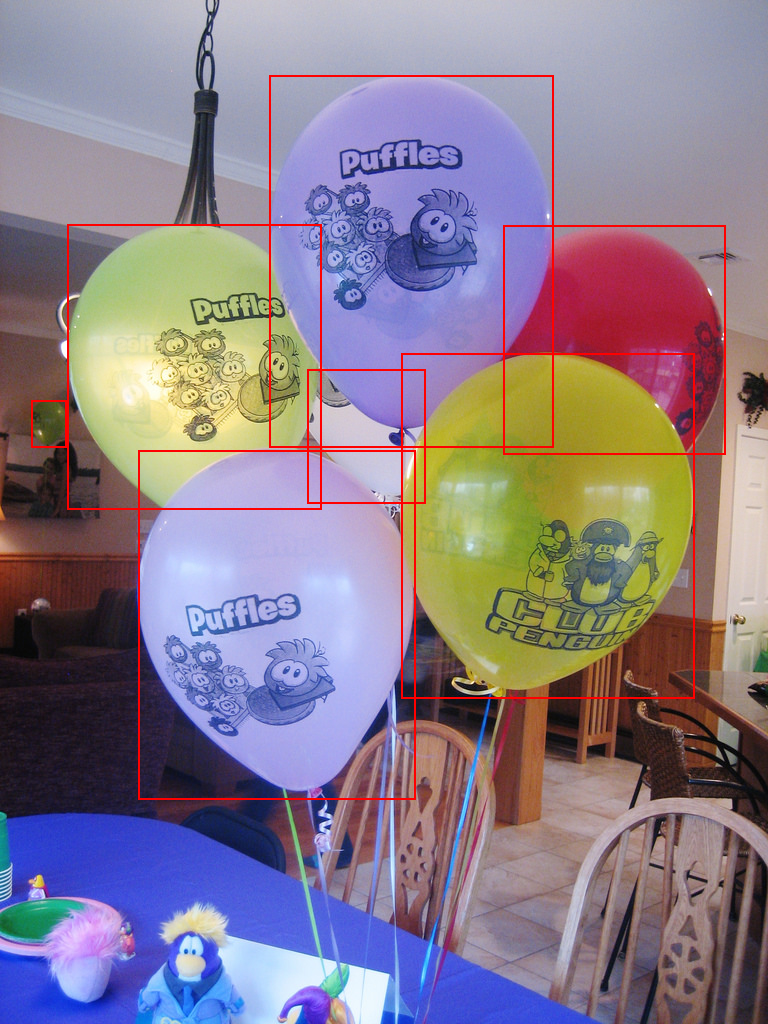

In [13]:
from pathlib import Path

root_path = './datasets/balloon/'
data_root = Path(root_path)

train_imgs = [str(x) for x in (data_root/'images'/'val').rglob("*.jpg") if 'checkpoint' not in str(x)]

img_path = train_imgs[0] 
label_path = img_path.replace('images','labels').replace('.jpg','.txt')
boxes = get_boxes(img_path,label_path)
plot_boxes(Image.open(img_path),boxes)


### 3，数据集配置文件

仿照 ultralytics/data/yolo/data/datasets 中已有的一些yaml数据集配置文件，构建我们自己的数据集yaml文件。


In [22]:
%%writefile balloon.yaml
# Ultralytics YOLO 🚀, GPL-3.0 license

path: balloon   # dataset root dir
train: images/train  # train images (relative to 'path') 128 images
val: images/val  # val images (relative to 'path') 128 images
test:  # test images (optional)

# Classes
names:
  0: ballon


Overwriting balloon.yaml


### 4，数据管道

In [23]:
import torch
from torch.utils.data import DataLoader
from ultralytics.cfg import get_cfg
from ultralytics.utils import DEFAULT_CFG,yaml_load 
from ultralytics.data.utils import check_cls_dataset, check_det_dataset
from ultralytics.data import build_yolo_dataset,build_dataloader

overrides = {'task':'detect',
             'data': 'balloon.yaml',
             'imgsz':640,
             'workers':4
            }
cfg = get_cfg(cfg = DEFAULT_CFG,overrides=overrides)
data_info = check_det_dataset(cfg.data)


In [25]:
ds_train = build_yolo_dataset(cfg,img_path=data_info['train'],batch=cfg.batch,
                              data = data_info,mode='train',rect=False,stride=32)

ds_val = build_yolo_dataset(cfg,img_path=data_info['val'],batch=cfg.batch,data = data_info,
    mode='val',rect=False,stride=32)




train: Scanning /tf/liangyun2/cashier/datasets/balloon/labels/train... 61 images, 2 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:00<00:00, 2198.95it/s]
train: New cache created: /tf/liangyun2/cashier/datasets/balloon/labels/train.cache
val: Scanning /tf/liangyun2/cashier/datasets/balloon/labels/val... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<00:00, 1758.50it/s]
val: New cache created: /tf/liangyun2/cashier/datasets/balloon/labels/val.cache


In [26]:
dl_train = DataLoader(ds_train,batch_size = cfg.batch, num_workers = cfg.workers,
                      collate_fn = ds_train.collate_fn)

dl_val = DataLoader(ds_val,batch_size = cfg.batch, num_workers = cfg.workers,
                      collate_fn = ds_val.collate_fn)


In [27]:
for batch in dl_val:
    break 

In [28]:
batch.keys()

dict_keys(['im_file', 'ori_shape', 'resized_shape', 'ratio_pad', 'img', 'cls', 'bboxes', 'batch_idx'])

## 二，定义模型

可以选择 yolov8n-seg,yolov8s-seg,yolov8m-seg,yolov8l-seg,yolov8x-seg等官方定义好的模型结构，

也可以通过修改yaml模型配置文件来实现用户自定义的模型结构。

In [32]:
from ultralytics.nn.tasks import DetectionModel

model = DetectionModel(cfg = 'yolov8n.yaml', ch=3, nc=1)
#weights = torch.hub.load_state_dict_from_url('https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8n.pt')
weights = torch.load('yolov8n.pt')
model.load(weights['model'])


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

In [34]:
model.args = cfg
model.nc = data_info['nc']  # attach number of classes to model
model.names = data_info['names']


## 三，训练模型

我们分别演示使用ultralytics原生接口以及使用torchkeras的KerasModel两种接口训练模型的方法。

### 1，使用ultralytics原生接口

如果是使用ultralytics的原生接口，只需要以下几行代码即可。



In [30]:
from ultralytics import YOLO 
yolo_model = YOLO('yolov8n.pt')

yolo_model.train(data='balloon.yaml',epochs=10)


New https://pypi.org/project/ultralytics/8.0.180 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.175 🚀 Python-3.8.10 torch-2.0.1+cu117 CUDA:0 (NVIDIA A100 80GB PCIe, 81070MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=balloon.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agno

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f138cf99e80>
fitness: 0.36470940405369684
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.35955])
names: {0: 'ballon'}
plot: True
results_dict: {'metrics/precision(B)': 0.8991675157483128, 'metrics/recall(B)': 0.3, 'metrics/mAP50(B)': 0.4111145244267099, 'metrics/mAP50-95(B)': 0.35955327956780647, 'fitness': 0.36470940405369684}
save_dir: PosixPath('runs/detect/train2')
speed: {'preprocess': 0.07174565241887018, 'inference': 0.5171298980712891, 'loss': 0.0008436349722055288, 'postprocess': 0.7206109853891226}

### 2，使用torchkeras梦中情炉

In [35]:
#测试loss计算过程
for batch in dl_train:
    break
    
for key,value in batch.items():
    if isinstance(value,torch.Tensor):
        batch[key] = batch[key].cuda()
    
model = model.cuda()
model.train();
batch['img'] = batch['img'].float()/255.0
loss,_ = model.forward(batch)
loss 

tensor(74.3001, device='cuda:0', grad_fn=<MulBackward0>)

In [38]:
from torchkeras import KerasModel 

#我们需要修改StepRunner以适应Yolov8的数据集格式

class StepRunner:
    def __init__(self, net, loss_fn, accelerator, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator
        self.net.train() 

    
    def __call__(self, batch):
        
        batch['img'] = batch['img'].float()/255
        
        #loss
        loss,_ = model.forward(batch)

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 


In [39]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) 
keras_model = KerasModel(net = model, 
                         loss_fn = None, 
                         optimizer = optimizer)



<<<<<< ⚡️ cuda is used >>>>>>


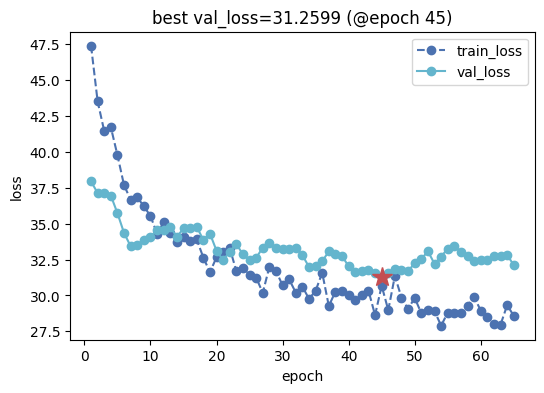

<<<<<< val_loss without improvement in 20 epoch,early stopping >>>>>> 



,epoch,train_loss,lr,val_loss
0,1,47.394963,0.0001,37.942341
1,2,43.512836,0.0001,37.134800
2,3,41.449062,0.0001,37.167404
3,4,41.714900,0.0001,36.953270
4,5,39.768025,0.0001,35.728584
...,...,...,...,...
60,61,28.482508,0.0001,32.465374
61,62,28.039936,0.0001,32.725273
62,63,27.966807,0.0001,32.717834
63,64,29.326236,0.0001,32.815521


In [42]:
keras_model.fit(train_data=dl_train,
                val_data=dl_val,
                epochs = 200,
                ckpt_path='checkpoint',
                patience=20,
                monitor='val_loss',
                mode='min',
                plot= True
               )

In [43]:
#关闭mosaic增强再训一次
ds_train.close_mosaic(cfg)
keras_model.from_scratch = False

<<<<<< ⚡️ cuda is used >>>>>>


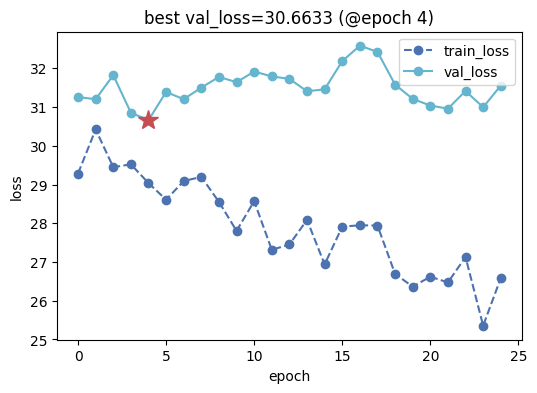

<<<<<< val_loss without improvement in 20 epoch,early stopping >>>>>> 



,epoch,train_loss,lr,val_loss
0,0,29.284948,0.0000,31.259914
1,1,30.423128,0.0001,31.203571
2,2,29.448510,0.0001,31.824892
3,3,29.522553,0.0001,30.855499
4,4,29.038334,0.0001,30.663296
5,5,28.608891,0.0001,31.389755
6,6,29.091991,0.0001,31.203611
7,7,29.198014,0.0001,31.503260
8,8,28.552580,0.0001,31.778975
9,9,27.804764,0.0001,31.644163


In [44]:
keras_model.fit(train_data=dl_train,
                val_data=dl_val,
                epochs = 200,
                ckpt_path='checkpoint',
                patience=20,
                monitor='val_loss',
                mode='min',
                mixed_precision='no',
                plot= True
               )

## 四，评估模型

为了便于评估 map等指标，我们将权重再次保存后，用ultralytics的原生YOLO接口进行加载后评估。


In [45]:
keras_model.evaluate(dl_val)

100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s, val_loss=30.7]


{'val_loss': 30.66329574584961}

In [47]:
from ultralytics import YOLO 
keras_model.load_ckpt(keras_model.ckpt_path)
save_dic = dict(model = keras_model.net, train_args =dict(cfg))
torch.save(save_dic, 'best_yolo.pt')



In [48]:
from ultralytics import YOLO 
best_model = YOLO(model = 'best_yolo.pt')
metrics = best_model.val(data = cfg.data )


Ultralytics YOLOv8.0.175 🚀 Python-3.8.10 torch-2.0.1+cu117 CUDA:0 (NVIDIA A100 80GB PCIe, 81070MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 12675 gradients, 8.1 GFLOPs
val: Scanning /tf/liangyun2/cashier/datasets/balloon/labels/val.cache... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]
                   all         13         50      0.796      0.782      0.821      0.719
Speed: 0.1ms preprocess, 4.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val


In [49]:
metrics.results_dict


{'metrics/precision(B)': 0.7962468655256904,
 'metrics/recall(B)': 0.7816096410758827,
 'metrics/mAP50(B)': 0.8212096988818037,
 'metrics/mAP50-95(B)': 0.7185766085203832,
 'fitness': 0.7288399175565253}

In [50]:
import pandas as pd 
df = pd.DataFrame()
df['metric'] = metrics.keys
for i,c in best_model.names.items():
    df[c] = metrics.class_result(i)

df 

,metric,ballon
0,metrics/precision(B),0.796247
1,metrics/recall(B),0.781610
2,metrics/mAP50(B),0.821210
3,metrics/mAP50-95(B),0.718577


## 五，使用模型


In [51]:
from pathlib import Path 
root_path = './datasets/balloon/'
data_root = Path(root_path)

best_model = YOLO(model = 'best_yolo.pt')


In [52]:
val_imgs = [str(x) for x in (data_root/'images'/'train').rglob("*.jpg") if 'checkpoint' not in str(x)]
img_path = val_imgs[5] 



image 1/1 /tf/liangyun2/cashier/datasets/balloon/images/train/1297451346_5b92bdac08_b.jpg: 640x480 4 ballons, 11.1ms
Speed: 1.9ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict


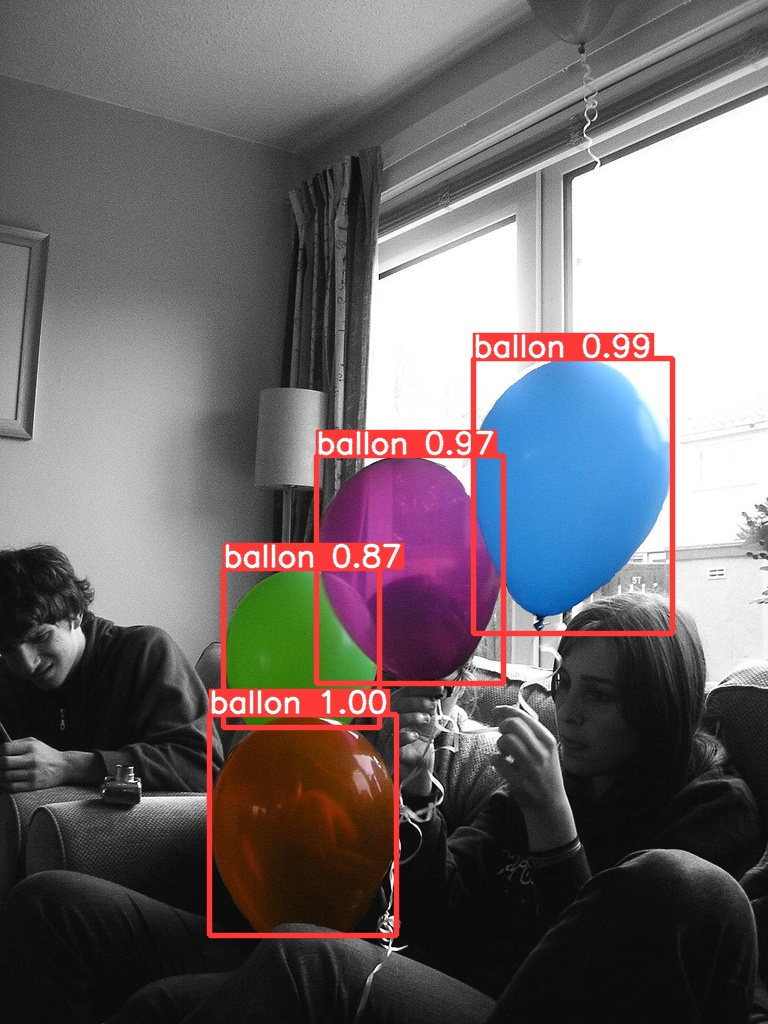

In [53]:
import os 
from PIL import Image 
result = best_model.predict(source = img_path,save=True)
best_model.predictor.save_dir/os.path.basename(img_path)
Image.open(best_model.predictor.save_dir/os.path.basename(img_path))


## 六，导出模型

Export a YOLOv8 model to any format.

Format                  | `format=...**bold text**`         | Model
---                     | ---                       | ---
PyTorch                 | -                         | yolov8n.pt
TorchScript             | `torchscript`             | yolov8n.torchscript
ONNX                    | `onnx`                    | yolov8n.onnx
OpenVINO                | `openvino`                | yolov8n_openvino_model/
TensorRT                | `engine`                  | yolov8n.engine
CoreML                  | `coreml`                  | yolov8n.mlmodel
TensorFlow SavedModel   | `saved_model`             | yolov8n_saved_model/
TensorFlow GraphDef     | `pb`                      | yolov8n.pb
TensorFlow Lite         | `tflite`                  | yolov8n.tflite
TensorFlow Edge TPU     | `edgetpu`                 | yolov8n_edgetpu.tflite
TensorFlow.js           | `tfjs`                    | yolov8n_web_model/
PaddlePaddle            | `paddle`                  | yolov8n_paddle_model/

In [54]:
best_model.export(format='onnx')

Ultralytics YOLOv8.0.175 🚀 Python-3.8.10 torch-2.0.1+cu117 CPU (Intel Xeon Gold 5318Y 2.10GHz)

PyTorch: starting from 'best_yolo.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (11.7 MB)

ONNX: starting export with onnx 1.13.0 opset 17...
ONNX: export success ✅ 0.7s, saved as 'best_yolo.onnx' (11.7 MB)

Export complete (2.2s)
Results saved to /tf/liangyun2/cashier
Predict:         yolo predict task=detect model=best_yolo.onnx imgsz=640  
Validate:        yolo val task=detect model=best_yolo.onnx imgsz=640 data=balloon.yaml  
Visualize:       https://netron.app


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



'best_yolo.onnx'

In [55]:
from ultralytics.yolo.v8.detect.predict import DetectionPredictor
predictor = DetectionPredictor(
    overrides=dict(model='best_yolo.onnx'))

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.


In [56]:
results = list(predictor.stream_inference(source=img_path)) 


Ultralytics YOLOv8.0.175 🚀 Python-3.8.10 torch-2.0.1+cu117 CUDA:0 (NVIDIA A100 80GB PCIe, 81070MiB)
Loading best_yolo.onnx for ONNX Runtime inference...
image 1/1 /tf/liangyun2/cashier/datasets/balloon/images/train/1297451346_5b92bdac08_b.jpg: 640x640 4 ballons, 40.7ms
Speed: 2.3ms preprocess, 40.7ms inference, 12.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train3


**如果本项目对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果在torchkeras的使用中遇到问题，可以在项目中提交issue。

如果想要获得更快的反馈或者与其他torchkeras用户小伙伴进行交流，

可以在公众号算法美食屋后台回复关键字：**加群**。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)